# 1.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 讀xml檔案

In [2]:
import xml.etree.ElementTree as ET

In [3]:
def loaddata(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  namespace = {'cwa': root.tag.split('}')[0][1:]}
  geo_info_node = root.find('./cwa:dataset/cwa:GeoInfo', namespace)
  start_lon_str = geo_info_node.find('cwa:BottomLeftLongitude', namespace).text
  start_lat_str = geo_info_node.find('cwa:BottomLeftLatitude', namespace).text
  start_lon = float(start_lon_str)
  start_lat = float(start_lat_str)
  content_node = root.find('./cwa:dataset/cwa:Resource/cwa:Content', namespace)
  raw_data_string = content_node.text.strip()
  lines = raw_data_string.splitlines()
  grid_data = []
  for line in lines:
      line_content = line.strip()
      if not line_content: continue
      values_str = line_content.replace('  ', ' ').split(',')
      values = [float(v) for v in values_str if v.strip()]
      if values: grid_data.append(values)
  return grid_data, start_lon, start_lat

In [4]:
file_path = '/content/O-A0038-003.xml'
grid_data, start_lon, start_lat = loaddata(file_path)

In [5]:
# 準備分類資料
all_classification_points = []
resolution = 0.03
for r_idx, row in enumerate(grid_data):
   for c_idx, temp_c in enumerate(row):
      lon = start_lon + c_idx * resolution
      lat = start_lat + r_idx * resolution
      label = 0 if temp_c == -999.0 else 1
      all_classification_points.append([lon, lat, label])

classification_data_np = np.array(all_classification_points)
X_class, y_class = classification_data_np[:, :2], classification_data_np[:, 2]

## GDA

In [6]:
class QDA_from_scratch:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.covs = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        for c in self.classes:
            X_c = X[y == c]
            # 1. 計算先驗機率 P(y=c)
            self.priors[c] = X_c.shape[0] / n_samples
            # 2. 計算平均向量 μ_c
            self.means[c] = np.mean(X_c, axis=0)
            # 3. 計算協方差矩陣 Σ_c
            # rowvar=False 表示每行為一個樣本，每列為一個特徵
            self.covs[c] = np.cov(X_c, rowvar=False)

    def predict(self, X):

        n_samples = X.shape[0]
        n_classes = len(self.classes)

        log_discriminants = np.zeros((n_samples, n_classes))

        for c in self.classes:
            prior = self.priors[c]
            mean = self.means[c]
            cov = self.covs[c]

            # 計算協方差矩陣的行列式和逆矩陣
            sign, logdet = np.linalg.slogdet(cov)
            inv_cov = np.linalg.inv(cov)

            # 計算每個樣本的對數判別分數
            for i, x_i in enumerate(X):
                diff = (x_i - mean).reshape(-1, 1)
                term1 = -0.5 * logdet
                term2 = -0.5 * (diff.T @ inv_cov @ diff)
                term3 = np.log(prior)
                log_discriminants[i, int(c)] = term1 + term2 + term3
        return self.classes[np.argmax(log_discriminants, axis=1)]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=123, stratify=y_class
)

qda_model = QDA_from_scratch()
qda_model.fit(X_train, y_train)

y_pred = qda_model.predict(X_test)

/tmp/ipython-input-3176941431.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_discriminants[i, int(c)] = term1 + term2 + term3


In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"測試集準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")

測試集準確率: 0.8221 (82.21%)


## 繪圖

/tmp/ipython-input-3176941431.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_discriminants[i, int(c)] = term1 + term2 + term3


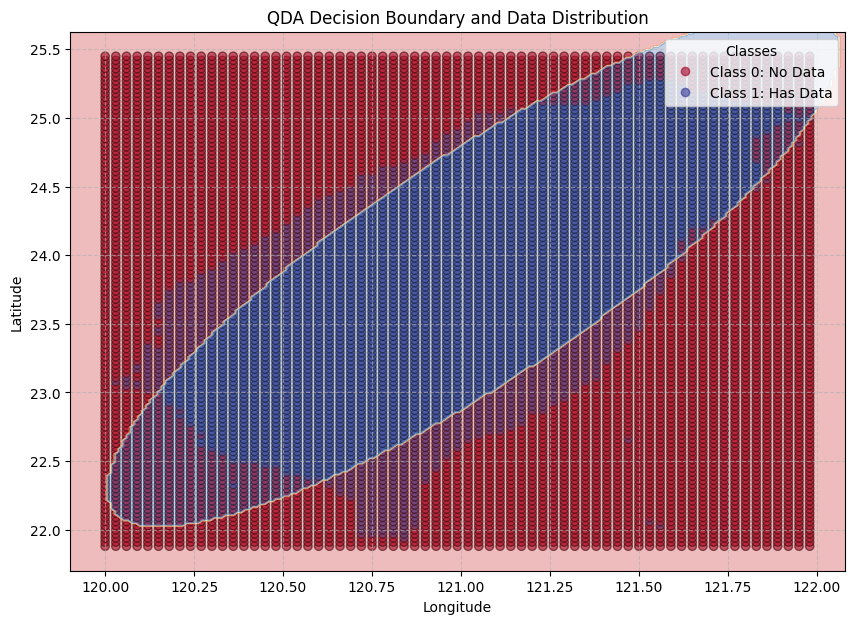

In [13]:
def plot_decision_boundary(X, y, model, title):
    plt.figure(figsize=(10, 7))

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', alpha=0.6)
    ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.3)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    handles, labels = scatter.legend_elements()
    legend_labels = ['Class 0: No Data', 'Class 1: Has Data']
    plt.legend(handles, legend_labels, title="Classes")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
plot_decision_boundary(X_class, y_class, qda_model, "QDA Decision Boundary and Data Distribution")


# 2.

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D

## 回歸資料

In [17]:
def loaddata(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  namespace = {'cwa': root.tag.split('}')[0][1:]}
  geo_info_node = root.find('./cwa:dataset/cwa:GeoInfo', namespace)
  start_lon_str = geo_info_node.find('cwa:BottomLeftLongitude', namespace).text
  start_lat_str = geo_info_node.find('cwa:BottomLeftLatitude', namespace).text
  start_lon = float(start_lon_str)
  start_lat = float(start_lat_str)
  content_node = root.find('./cwa:dataset/cwa:Resource/cwa:Content', namespace)
  raw_data_string = content_node.text.strip()
  lines = raw_data_string.splitlines()
  grid_data = []
  for line in lines:
      line_content = line.strip()
      if not line_content: continue
      values_str = line_content.replace('  ', ' ').split(',')
      values = [float(v) for v in values_str if v.strip()]
      if values: grid_data.append(values)
  return grid_data, start_lon, start_lat

In [19]:
file_path = '/content/O-A0038-003.xml'
grid_data, start_lon, start_lat = loaddata(file_path)

all_points = []
resolution = 0.03
for r_idx, row in enumerate(grid_data):
    for c_idx, temp_c in enumerate(row):
        lon = start_lon + c_idx * resolution
        lat = start_lat + r_idx * resolution
        label = 0 if temp_c == -999.0 else 1
        all_points.append([lon, lat, label, temp_c])

all_data_np = np.array(all_points)

X_all = all_data_np[:, :2]
y_class = all_data_np[:, 2]
temps_all = all_data_np[:, 3]

## C(x)

In [20]:
C_x = QDA_from_scratch()
C_x.fit(X_all, y_class)

## R(x)

In [22]:
is_valid_temp = (temps_all != -999.0)
X_reg = X_all[is_valid_temp]
y_reg = temps_all[is_valid_temp]

degree = 4
R_x = make_pipeline(PolynomialFeatures(degree), LinearRegression())
R_x.fit(X_reg, y_reg)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

## 組合模型 h(x)

In [28]:
def h(X, classifier, regressor):
    class_predictions = classifier.predict(X)
    regression_predictions = regressor.predict(X)
    final_output = np.full(X.shape[0], -999.0)
    is_class_1 = (class_predictions == 1)
    final_output[is_class_1] = regression_predictions[is_class_1]
    return final_output

In [29]:
point_inside = np.mean(X_reg, axis=0)

point_outside = np.array([start_lon, start_lat])

test_points = np.vstack([point_inside, point_outside])
h_predictions = h(test_points, C_x, R_x)

print(f"測試點 (內 - 中心點) {point_inside}: h(x) 輸出 = {h_predictions[0]:.2f}")
print(f"測試點 (外) {point_outside}: h(x) 輸出 = {h_predictions[1]:.2f}")


測試點 (內 - 中心點) [120.97071245  23.74593133]: h(x) 輸出 = 13.84
測試點 (外) [120.    21.88]: h(x) 輸出 = -999.00


/tmp/ipython-input-3176941431.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_discriminants[i, int(c)] = term1 + term2 + term3


## 視覺化


/tmp/ipython-input-3176941431.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_discriminants[i, int(c)] = term1 + term2 + term3


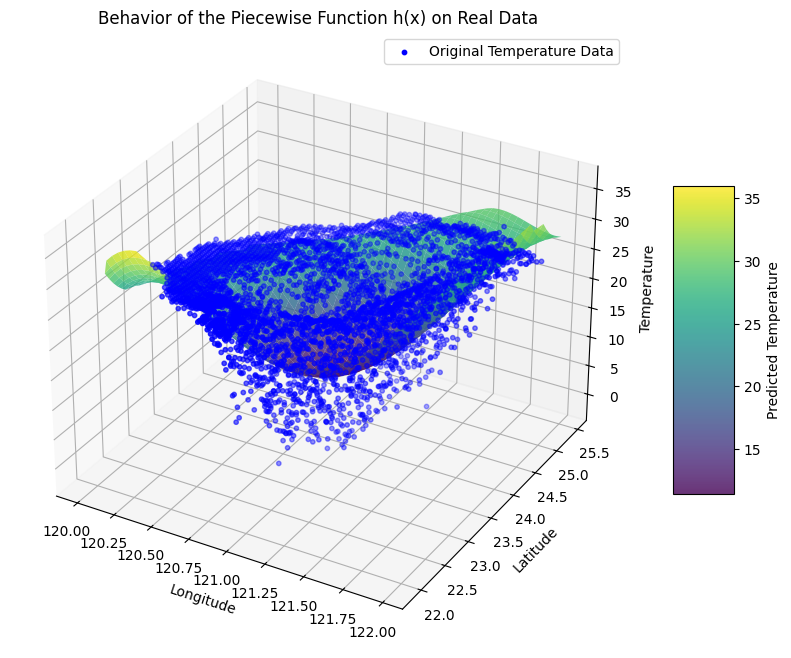

In [30]:
def plot_3d_regression(X_all, X_reg, y_reg, h_func, classifier, regressor):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_min, x_max = X_all[:, 0].min(), X_all[:, 0].max()
    y_min, y_max = X_all[:, 1].min(), X_all[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 使用 h(x) 預測整個網格的值
    Z = h_func(grid_points, classifier, regressor)
    Z[Z == -999] = np.nan
    Z = Z.reshape(xx.shape)

    surf = ax.plot_surface(xx, yy, Z, cmap='viridis', alpha=0.8, edgecolor='none')

    ax.scatter(X_reg[:, 0], X_reg[:, 1], y_reg, c='blue', marker='o', s=10, label='Original Temperature Data')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Temperature')
    ax.set_title('Behavior of the Piecewise Function h(x) on Real Data')
    ax.legend()
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Predicted Temperature')
    plt.show()

plot_3d_regression(X_all, X_reg, y_reg, h, C_x, R_x)